 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/energy_conservation.ipynb#Load-sample-file" data-toc-modified-id="Load-sample-file-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load sample file</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/energy_conservation.ipynb#Define-some-helper-functions" data-toc-modified-id="Define-some-helper-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Define some helper functions</a></span></li><li><span><a href="http://localhost:8888/notebooks/energy_conservation.ipynb#Get-pressure-level-differences-and-define-vertical-integration" data-toc-modified-id="Get-pressure-level-differences-and-define-vertical-integration-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Get pressure level differences and define vertical integration</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/energy_conservation.ipynb#Get-variables-statistics." data-toc-modified-id="Get-variables-statistics.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get variables statistics.</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/energy_conservation.ipynb#Temperature-variables" data-toc-modified-id="Temperature-variables-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Temperature variables</a></span></li><li><span><a href="http://localhost:8888/notebooks/energy_conservation.ipynb#Humidity-variables" data-toc-modified-id="Humidity-variables-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Humidity variables</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/energy_conservation.ipynb#Variable-relations" data-toc-modified-id="Variable-relations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Variable relations</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/energy_conservation.ipynb#Total-physics-tendencies" data-toc-modified-id="Total-physics-tendencies-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Total physics tendencies</a></span></li><li><span><a href="http://localhost:8888/notebooks/energy_conservation.ipynb#Fluxes-and-vertical-diffusion-terms" data-toc-modified-id="Fluxes-and-vertical-diffusion-terms-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Fluxes and vertical diffusion terms</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/energy_conservation.ipynb#Moisture-conservation" data-toc-modified-id="Moisture-conservation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Moisture conservation</a></span></li><li><span><a href="http://localhost:8888/notebooks/energy_conservation.ipynb#Moist-static-energy-conservation" data-toc-modified-id="Moist-static-energy-conservation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Moist static energy conservation</a></span></li><li><span><a href="http://localhost:8888/notebooks/energy_conservation.ipynb#Questions" data-toc-modified-id="Questions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Questions</a></span></li></ul></div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Load-sample-file" data-toc-modified-id="Load-sample-file-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load sample file</a></span></li><li><span><a href="#Check-Physics-tendencies" data-toc-modified-id="Check-Physics-tendencies-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Check Physics tendencies</a></span></li><li><span><a href="#Test-moisture-and-MSE-conservation" data-toc-modified-id="Test-moisture-and-MSE-conservation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test moisture and MSE conservation</a></span><ul class="toc-item"><li><span><a href="#Compute-the-vertical-pressure-difference" data-toc-modified-id="Compute-the-vertical-pressure-difference-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Compute the vertical pressure difference</a></span></li><li><span><a href="#Moisture-budget" data-toc-modified-id="Moisture-budget-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Moisture budget</a></span></li><li><span><a href="#Moist-static-energy-budget" data-toc-modified-id="Moist-static-energy-budget-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Moist static energy budget</a></span></li></ul></li><li><span><a href="#Questions" data-toc-modified-id="Questions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Questions</a></span></li></ul></div>

# SP-CAM variables - statistics and their relation

Check how variables relate to conserve energy. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.core.debugger as pdb
import sys
sys.path.append('../../data_processing')
from preprocess_aqua import compute_adiabatic

## Load sample file

Let's load a recent enhanced SP-CAM run with additional variables.

In [2]:
path = '/Users/stephanrasp/data/SP-CAM/AndKua_aqua_SPCAM3.0_enhance02.cam2.h1.0000-02-01-00000.nc'

In [3]:
# Load one file (containing one day)
ds = xr.open_dataset(path, decode_times=False)

In [4]:
ds

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 48)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * lon           (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 ...
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 912.6 887.0 859.5 ...
  * lev           (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 ...
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 ...
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 90.01 90.02 90.04 ...
  * time          (time) float64 31.0 31.02 31.04 31.06 31.08 31.1 31.12 ...
Dimensions wi

To make the analysis faster we will pick a few time steps and a longitude slice.

In [5]:
ds = ds.isel(time=[0, 1, 2])
ds = ds.isel(lon=range(40, 90))

In [6]:
ds.SPDQ.shape

(3, 30, 64, 50)

### Define some helper functions

In [7]:
def scat(x, y, **kwargs):
    x = np.ravel(x); y = np.ravel(y)
    plt.scatter(x, y, **kwargs)
    mn = np.min([x, y])
    mx = np.max([x, y])
    plt.plot([mn, mx], [mn, mx], zorder=0.1, c='r')
    plt.xlim(mn, mx); plt.ylim(mn,mx)
    plt.show()

In [8]:
def hist(x):
    plt.hist(np.ravel(x), bins=50)
    plt.show()

In [9]:
def vert_mean(da, ax=None):
    if ax is None: fig, ax = plt.subplots(1, 1)
    ax.plot(da.mean(dim=('time', 'lat', 'lon')), range(len(da.lev)))
    ax.invert_yaxis()
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
    ax.set_title('Mean')
    
def vert_std(da, ax=None):
    if ax is None: fig, ax = plt.subplots(1, 1)
    ax.plot(da.std(dim=('time', 'lat', 'lon')), range(len(da.lev)))
    ax.invert_yaxis()
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
    ax.set_title('Std')

In [10]:
def plot_3D_stats(da):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    vert_mean(da, axes[0])
    vert_std(da, axes[1])
    plt.tight_layout(); plt.show()
    
    # Plot slices
    plt.imshow(da.values[-1, :, :, 0])
    plt.colorbar(shrink=0.5)
    plt.tight_layout(); plt.show()

In [11]:
ds.TAP.shape

(3, 30, 64, 50)

### Get pressure level differences and define vertical integration

To do the vertical integrations, we need to compute the pressure differences. The actual pressure is computed as

p = P0 \* hyai + PS \* hybi

Then we can compute the vertical integrals as

vint(SPDQ) = sum(SPDQ \* p_diff) * L_V / G

In [12]:
def get_p_diff(ds):
    p = ds.P0 * ds.hyai + ds.PS * ds.hybi
    p_diff = np.diff(p.values, axis=0)
    return np.rollaxis(p_diff, 0, 2)

In [13]:
p_diff = get_p_diff(ds)

In [14]:
L_V = 2.501e6   # Latent heat of vaporization
L_I = 3.337e5   # Latent heat of freezing
L_S = L_V + L_I # Sublimation
C_P = 1e3 # Specific heat capacity of air at constant pressure
G = 9.81

In [15]:
def vint(x, factor):
    p_diff_tmp = p_diff[1:] if x.shape[0] == p_diff.shape[0] - 1 else p_diff
    return np.sum(x.values * factor * p_diff_tmp / G, 1)

## Get variables statistics.

### Temperature variables

- T
- TAP
- TPHYSTND
- compute dTdt_adiabatic
- DTV
- DTVKE
- SPDT
- QRL
- QRS

#### T

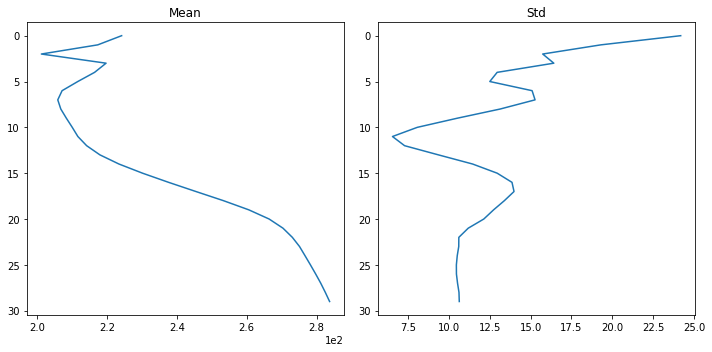

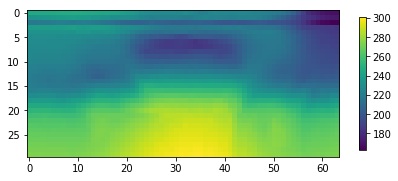

In [16]:
plot_3D_stats(ds['T'])

#### TAP

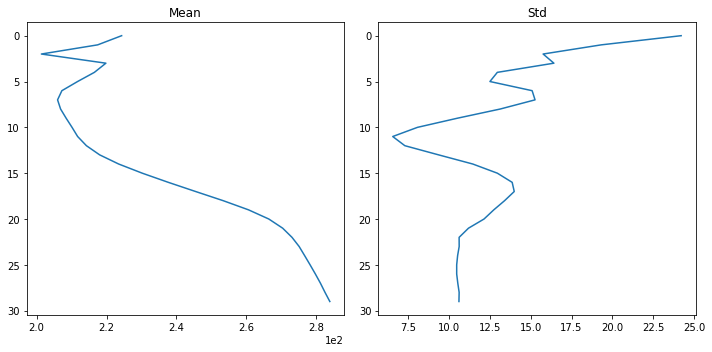

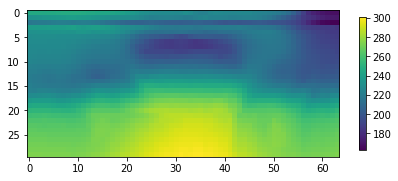

In [17]:
plot_3D_stats(ds['TAP'])

#### TPHYSTND

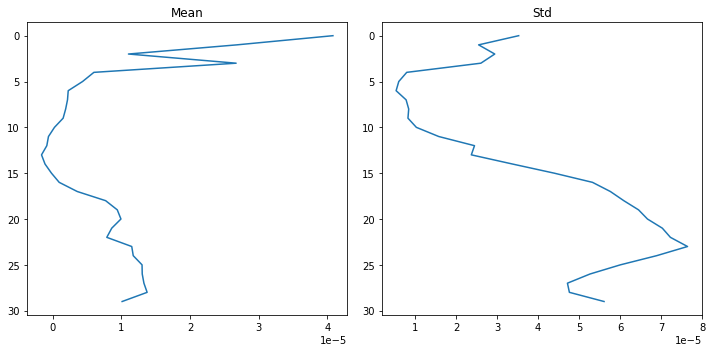

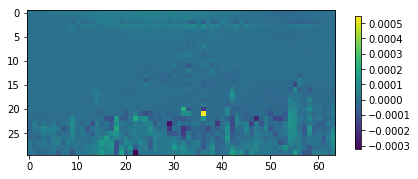

In [18]:
plot_3D_stats(ds['TPHYSTND'])

#### dTdt_adiabatic

In [19]:
dTdt_adiabatic = compute_adiabatic(ds, 'dTdt_adiabatic')

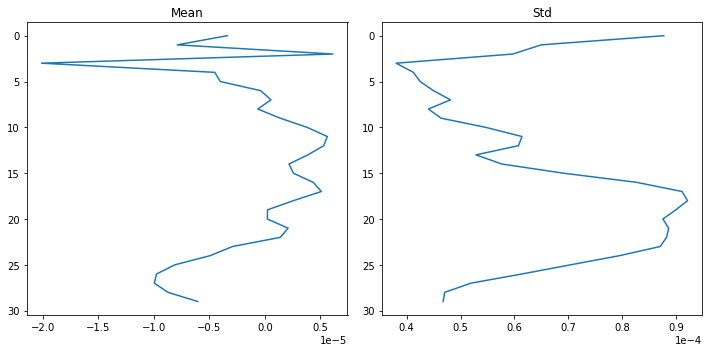

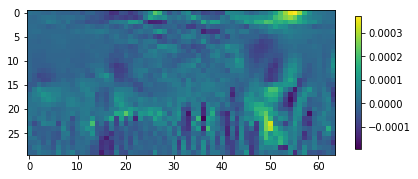

In [20]:
plot_3D_stats(dTdt_adiabatic)

#### QRL

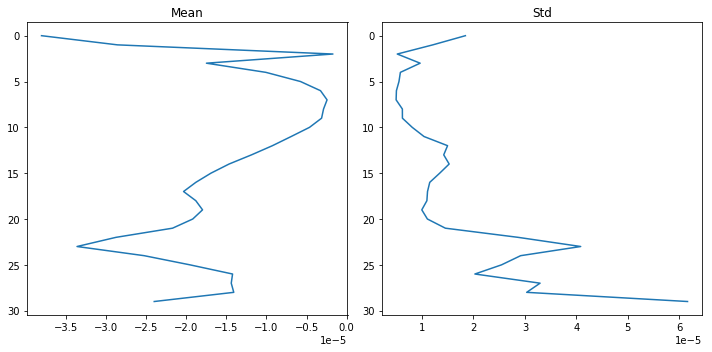

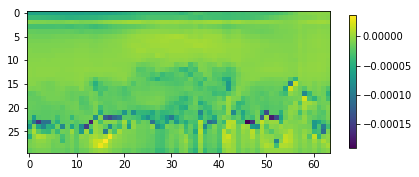

In [21]:
plot_3D_stats(ds['QRL'])

#### QRS

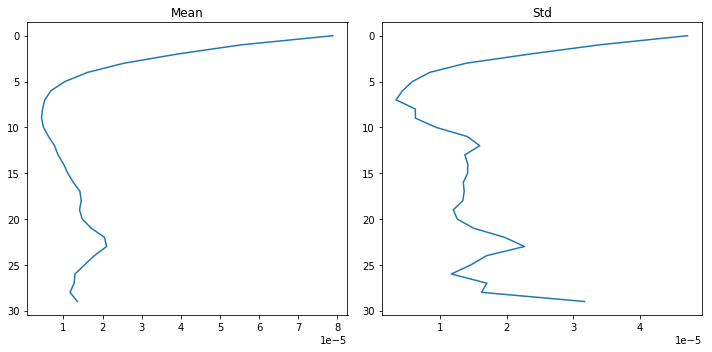

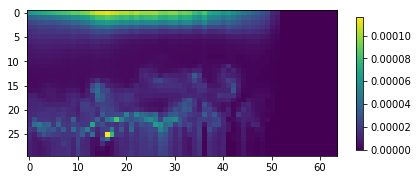

In [22]:
plot_3D_stats(ds['QRS'])

#### TPHYSTND_NORAD

In [23]:
TPHYSTND_NORAD = ds.TPHYSTND - ds.QRL - ds.QRS

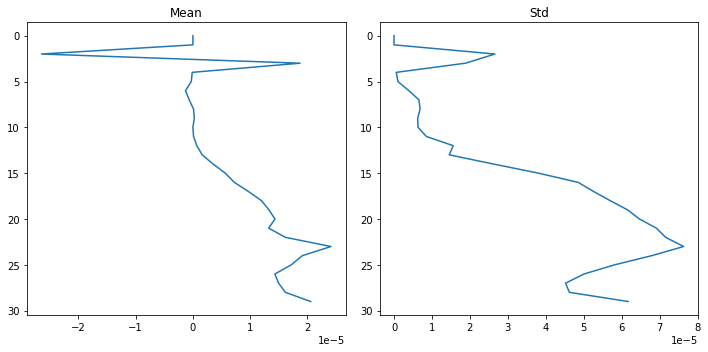

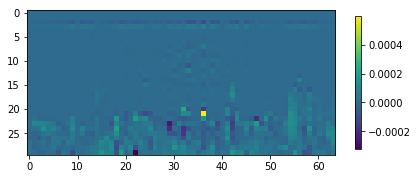

In [24]:
plot_3D_stats(TPHYSTND_NORAD)

#### SPDT

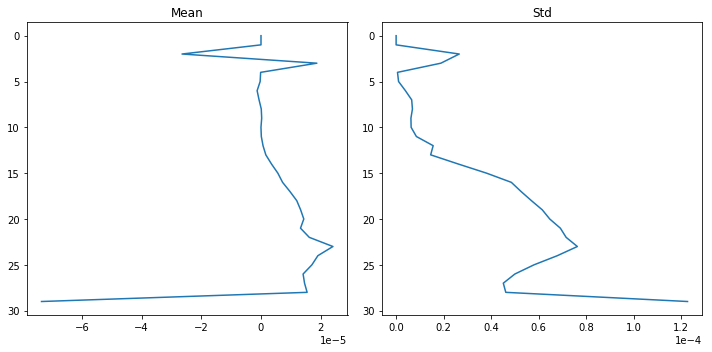

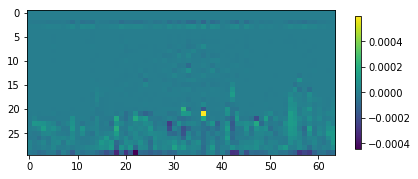

In [25]:
plot_3D_stats(ds['SPDT'])

#### DTV

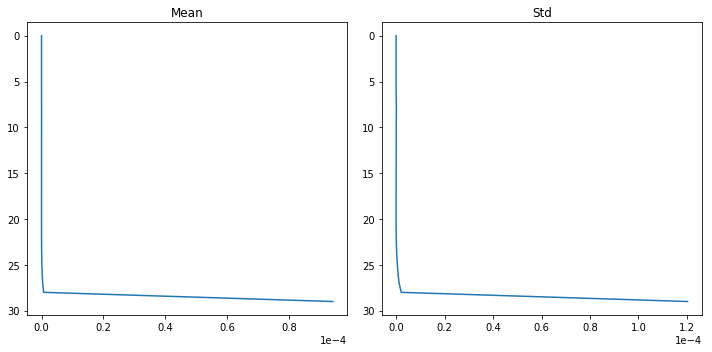

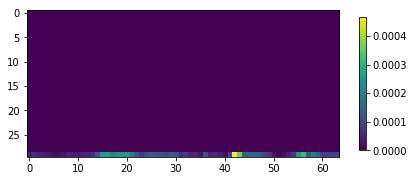

In [26]:
plot_3D_stats(ds['DTV'])

#### DTVKE

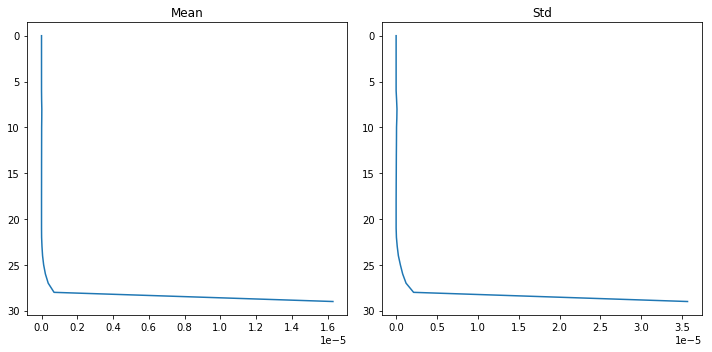

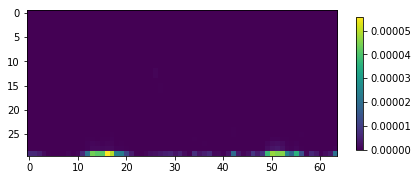

In [27]:
plot_3D_stats(ds['DTVKE'] / 1800.)

### Humidity variables

- Q
- QAP
- PHQ
- PHCLDLIQ
- PHCLDICE
- dQdt_adiabatic
- VD01
- SPDQ
- SPDQC
- SPDQI

#### QAP

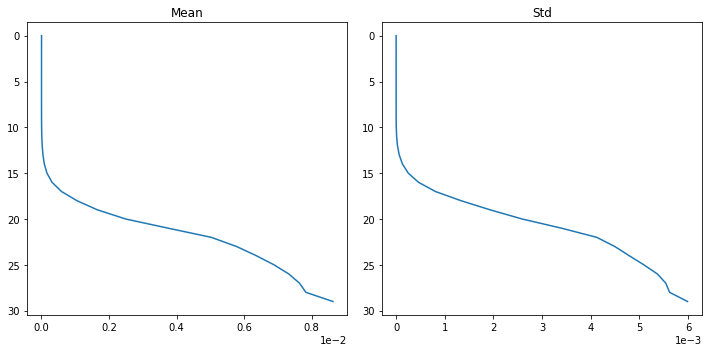

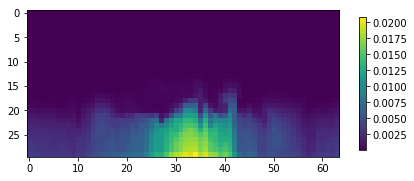

In [28]:
plot_3D_stats(ds['QAP'])

#### PHQ

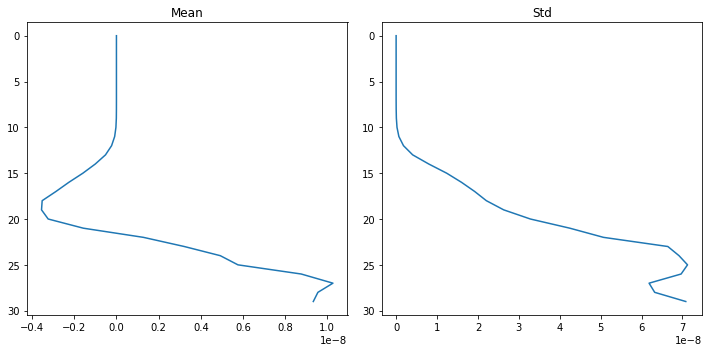

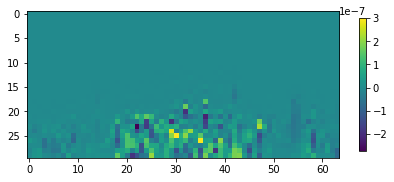

In [29]:
plot_3D_stats(ds['PHQ'])

#### PHCLDLIQ

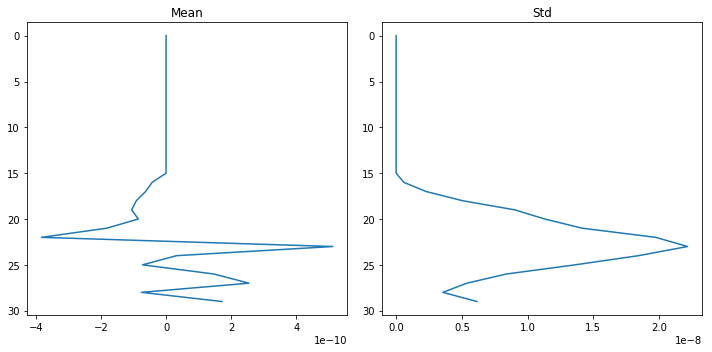

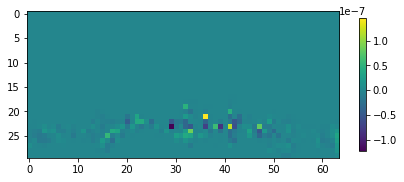

In [30]:
plot_3D_stats(ds['PHCLDLIQ'])

#### PHCLDICE

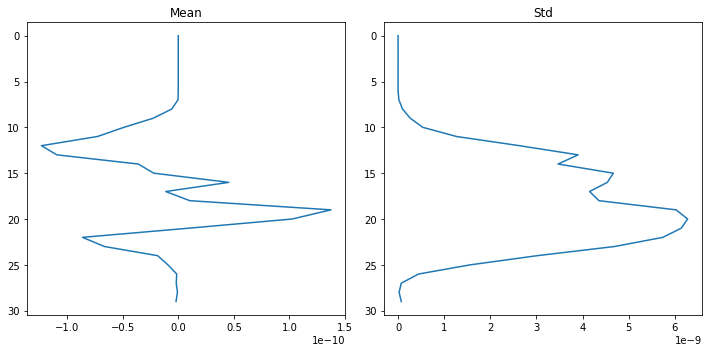

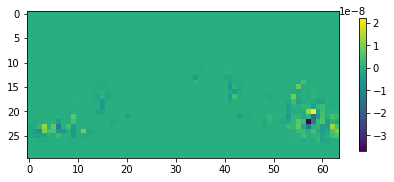

In [31]:
plot_3D_stats(ds['PHCLDICE'])

#### dQdt_adiabatic

In [32]:
dQdt_adiabatic = compute_adiabatic(ds, 'dQdt_adiabatic')

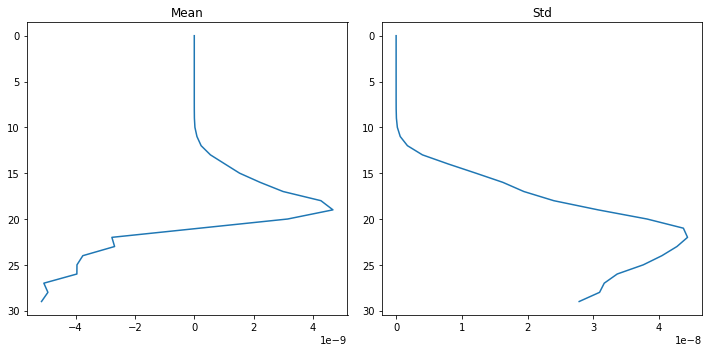

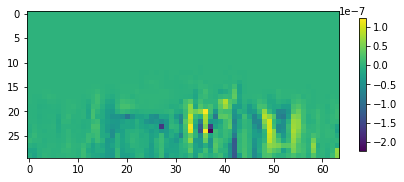

In [33]:
plot_3D_stats(dQdt_adiabatic)

#### VD01

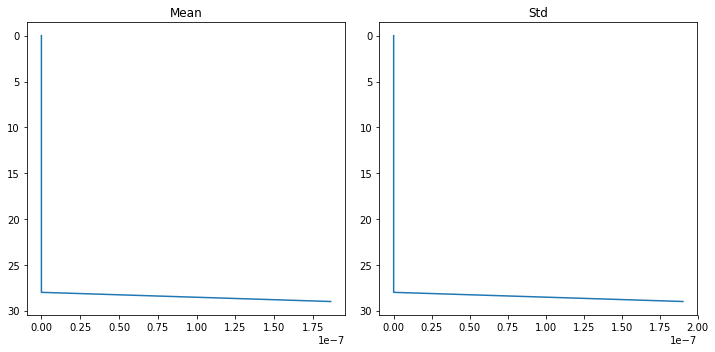

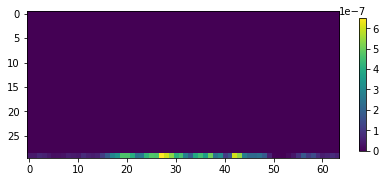

In [34]:
plot_3D_stats(ds['VD01'])

#### SPDQ

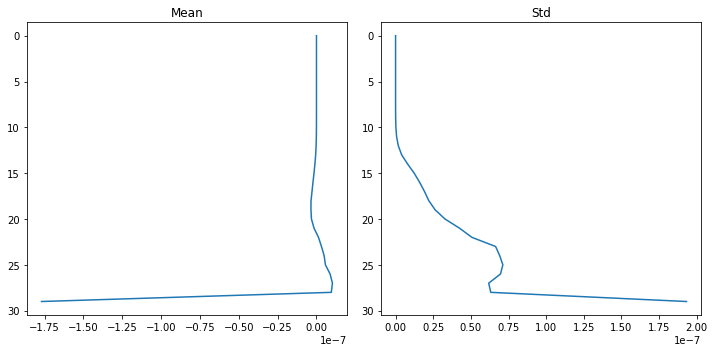

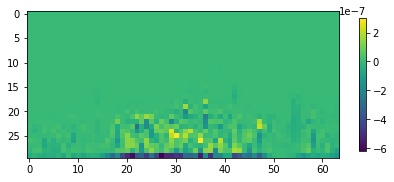

In [35]:
plot_3D_stats(ds['SPDQ'])

#### SPDQC

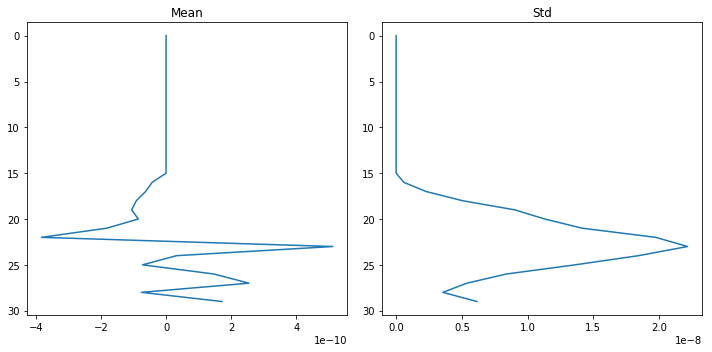

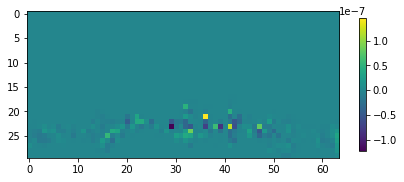

In [36]:
plot_3D_stats(ds['SPDQC'])

#### SPDQI

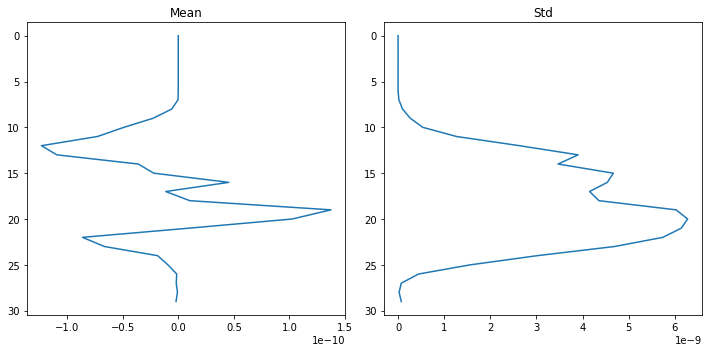

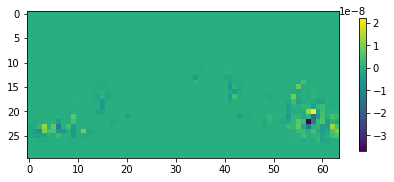

In [37]:
plot_3D_stats(ds['SPDQI'])

## Variable relations

### Total physics tendencies

#### TPHYSTND = SPDT + DTV + QRS + QRL. Exactly true!

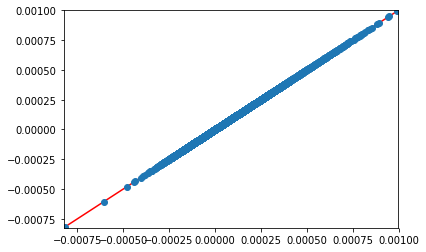

In [38]:
scat(ds.TPHYSTND, ds.SPDT + ds.DTV + ds.QRS + ds.QRL)

#### PHQ = SPDQ + VD01. Exactly True!

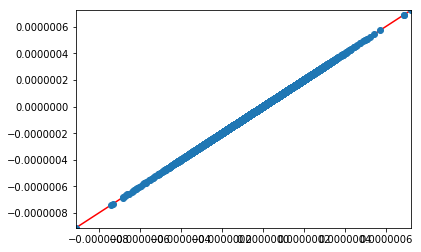

In [39]:
scat(ds.PHQ, ds.SPDQ + ds.VD01)

#### PHCLDLIQ = SPDQC. Exactly true

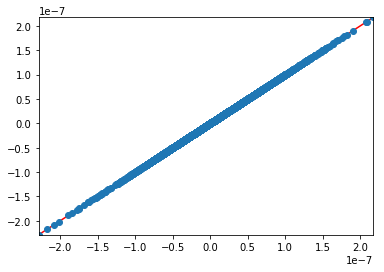

In [40]:
scat(ds.PHCLDLIQ, ds.SPDQC)

#### PHCLDICE = SPDQI. Exactly true

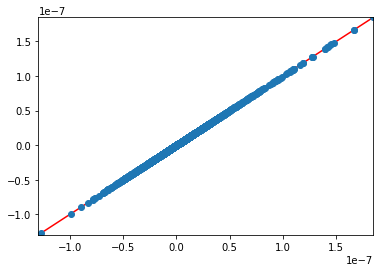

In [41]:
scat(ds.PHCLDICE, ds.SPDQI)

### Fluxes and vertical diffusion terms

#### LHFLX = VD01. Exactly true!

In [42]:
VD01_vint_LV = vint(ds.VD01, L_V)

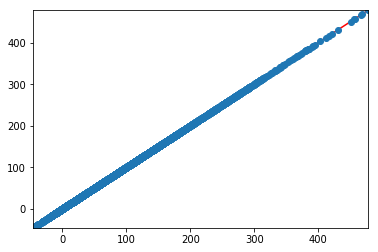

In [43]:
scat(ds.LHFLX, VD01_vint_LV)

#### SHFLX + DTVKE = DTV. Exactly true true!

In [44]:
DTV_vint_CP = vint(ds.DTV, C_P)

In [45]:
DTVKE_vint_CP = vint(ds.DTVKE, C_P) / 1800.  # Fortran code is missing 1/dt

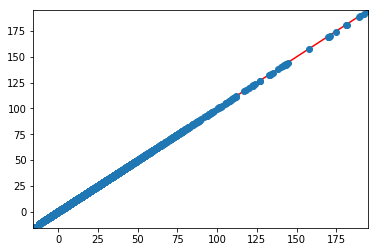

In [46]:
scat(ds.SHFLX + DTVKE_vint_CP, DTV_vint_CP)

#### T[t] = TAP[t+1] - TPHYSTND[t+1]\*dt

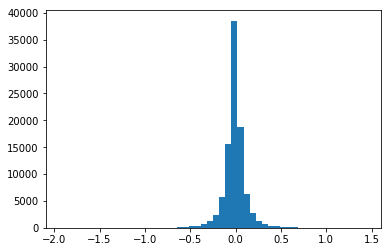

In [53]:
hist(ds['T'].values[0] - (ds['TAP'].values[1] - ds.TPHYSTND.values[1] * 1800.))

## Moisture conservation

The total column water should be conserved.

```
vint(SPDQ + SPDQC + SPDQI + VD01) = LHFLX/L_V - PRECT*1e3
```

Since `vint(VD01)*L_V = LHFLX`, we can simplify this to 

```
vint(SPDQ + SPDQC + SPDQI) = - PRECT*1e3
```

In [47]:
dTOT_WAT = vint(ds.SPDQ + ds.SPDQC + ds.SPDQI, 1)

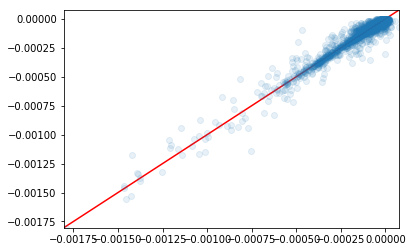

In [48]:
scat(dTOT_WAT, ds.PRECT * -1e3, alpha=0.1)

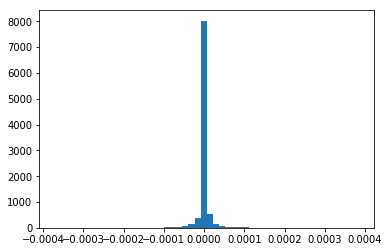

In [49]:
hist(dTOT_WAT + ds.PRECT * 1e3)

So this is not exact. What are we missing? Could it be the other hydrometeors that exist in the CRM but not in the GCM?

It doesn't seem to be a systematic bias, but rather some scatter around zero...

In [50]:
scat(SPDQ_vint, ds.PRECT * -1e3, alpha=0.1)

NameError: name 'SPDQ_vint' is not defined

## Moist static energy conservation

So the simple version ignoring liquid water and ice looks like this
```
vint(SPDT + DTV - DTVKE) * C_P + vint(SPDQ + VD01) * L_V = SHFLX + LHFLX
```
which reduces to 
```
vint(SPDT) * C_P + vint(SPDQ) * L_V = 0
```

In [302]:
SPDT_vint_CP = vint(ds.SPDT, C_P)
SPDQ_vint_LV = vint(ds.SPDQ, L_V)

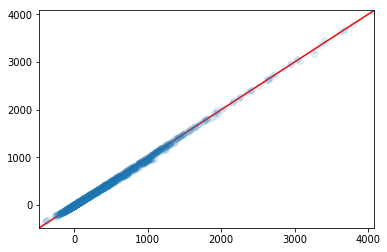

In [305]:
scat(SPDT_vint_CP, -SPDQ_vint_LV, alpha=0.1)

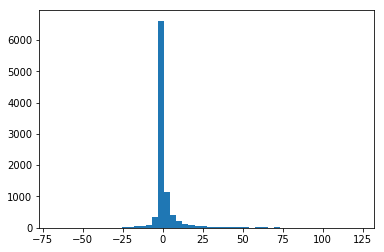

In [306]:
hist(SPDT_vint_CP + SPDQ_vint_LV)

A more complete version with hydrometeors would look like this. There can be the following transitions:
- 

```
vint(SPDT) * C_P + vint(SPDQ
```

Ok, erm, actually this requires some more thinking.

In [308]:
SPDQ_vint = vint(ds.SPDQ, 1)
SPDQC_vint = vint(ds.SPDQC, 1)
SPDQI_vint = vint(ds.SPDQI, 1)

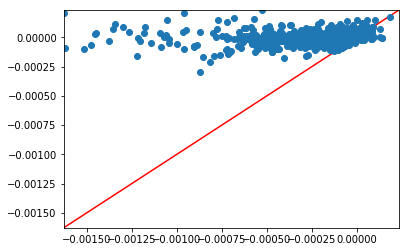

In [310]:
scat(SPDQ_vint, -SPDQC_vint)

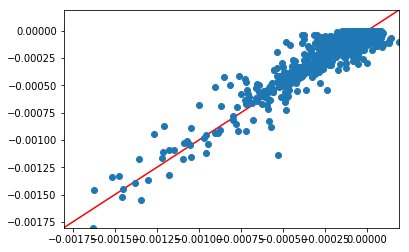

In [312]:
scat(SPDQ_vint, ds.PRECT * -1e3)

## Questions

1. Why is VD01 = LHFLX but DTV != SHFLX?
2. What is added SHFLX --> DTV?
3. Why is SPDQ_vint != PRECT?
4. What else except for (2.) is missing in SHFLX = SPDQ + SPDT + DTV?

In [119]:
(ds.TAP -ds.TPHYSTND*1800).isel(time=1)

<xarray.DataArray (lev: 30, lat: 10, lon: 50)>
array([[[ 228.197296,  228.061813, ...,  227.940582,  228.041168],
        [ 228.697037,  229.418472, ...,  227.310043,  226.839188],
        ..., 
        [ 227.788574,  227.219131, ...,  228.66124 ,  228.445007],
        [ 227.056366,  226.88205 , ...,  228.865616,  228.49025 ]],

       [[ 222.571823,  222.788345, ...,  221.972351,  221.378983],
        [ 221.901123,  221.451233, ...,  221.588394,  221.354919],
        ..., 
        [ 223.745239,  224.225052, ...,  221.607193,  221.553329],
        [ 224.048279,  224.089722, ...,  222.026642,  222.254578]],

       ..., 
       [[ 297.806549,  298.171417, ...,  299.571289,  299.310455],
        [ 298.807953,  298.459198, ...,  299.903229,  299.691132],
        ..., 
        [ 297.368011,  297.313599, ...,  295.837006,  295.572754],
        [ 296.265717,  296.053314, ...,  293.958069,  293.513031]],

       [[ 299.232178,  299.68399 , ...,  300.973206,  300.685364],
        [ 300.359375,

In [120]:
ds['T'].isel(time=0)

<xarray.DataArray 'T' (lev: 30, lat: 10, lon: 50)>
array([[[ 228.126801,  228.016006, ...,  227.839401,  227.941635],
        [ 228.704376,  229.447556, ...,  227.206161,  226.737289],
        ..., 
        [ 227.824295,  227.223953, ...,  228.468674,  228.315613],
        [ 227.145447,  226.964584, ...,  228.847214,  228.569946]],

       [[ 222.469376,  222.643326, ...,  222.019974,  221.350266],
        [ 221.777771,  221.311279, ...,  221.522583,  221.276779],
        ..., 
        [ 223.793701,  224.276459, ...,  221.522522,  221.517044],
        [ 224.091599,  224.15477 , ...,  221.845322,  222.079254]],

       ..., 
       [[ 297.860992,  298.220032, ...,  299.619415,  299.343506],
        [ 298.741577,  298.489349, ...,  299.95282 ,  299.803436],
        ..., 
        [ 297.422272,  297.334381, ...,  296.120209,  295.652527],
        [ 296.195923,  296.136322, ...,  294.124298,  293.653595]],

       [[ 299.087555,  299.611847, ...,  301.021637,  300.724091],
        [ 300.167

In [134]:
(ds.TAP -ds.TPHYSTND*1800).diff('time').isel(time=1)

<xarray.DataArray (lev: 30, lat: 10, lon: 50)>
array([[[ 0.081406,  0.060623, ...,  0.050385,  0.041214],
        [ 0.036392, -0.005569, ...,  0.037552,  0.028885],
        ..., 
        [-0.048431,  0.010849, ...,  0.174164,  0.128738],
        [-0.086792, -0.03949 , ..., -0.030975, -0.090408]],

       [[ 0.092789,  0.133194, ..., -0.087708,  0.00914 ],
        [ 0.143433,  0.16156 , ...,  0.04538 ,  0.065979],
        ..., 
        [-0.027328, -0.0289  , ...,  0.095123,  0.066376],
        [-0.051193, -0.054199, ...,  0.1604  ,  0.169891]],

       ..., 
       [[-0.129303,  0.018158, ...,  0.00058 , -0.078857],
        [-0.061859,  0.087341, ..., -0.037384, -0.025421],
        ..., 
        [ 0.007019,  0.041656, ..., -0.059692,  0.050354],
        [ 0.051727,  0.073303, ..., -0.022278, -0.071716]],

       [[-0.157501, -0.29657 , ...,  0.007202, -0.03653 ],
        [-0.007355,  0.131439, ..., -0.012115, -0.009613],
        ..., 
        [-0.012848,  0.039429, ..., -0.069702,  0.03

In [133]:
ds['T'].diff('time').isel(time=0)

<xarray.DataArray 'T' (lev: 30, lat: 10, lon: 50)>
array([[[  7.272339e-02,   5.055237e-02, ...,   1.020813e-01,   1.025085e-01],
        [ -2.288818e-04,  -2.612305e-02, ...,   1.065979e-01,   1.031494e-01],
        ..., 
        [ -2.503967e-02,  -1.373291e-04, ...,   1.982727e-01,   1.399231e-01],
        [ -8.361816e-02,  -8.018494e-02, ...,   1.980591e-02,  -7.896423e-02]],

       [[  1.051483e-01,   1.508484e-01, ...,  -4.650879e-02,   3.236389e-02],
        [  1.320648e-01,   1.436005e-01, ...,   6.913757e-02,   7.969666e-02],
        ..., 
        [ -3.535461e-02,  -4.565430e-02, ...,   9.164429e-02,   4.919434e-02],
        [ -3.660583e-02,  -6.216431e-02, ...,   1.830444e-01,   1.762238e-01]],

       ..., 
       [[ -2.660217e-01,   3.814697e-02, ...,  -1.553345e-02,  -2.325439e-02],
        [  1.709595e-01,   9.155273e-04, ...,  -3.750610e-02,  -4.351807e-02],
        ..., 
        [ -7.086182e-02,  -8.483887e-03, ...,  -1.824646e-01,   1.130066e-01],
        [  1.958923e-

In [135]:
ds['T']

<xarray.DataArray 'T' (time: 3, lev: 30, lat: 10, lon: 50)>
array([[[[ 228.126801, ...,  227.941635],
         ..., 
         [ 227.145447, ...,  228.569946]],

        ..., 
        [[ 299.087555, ...,  300.724091],
         ..., 
         [ 297.570709, ...,  295.241058]]],


       ..., 
       [[[ 228.282364, ...,  228.08429 ],
         ..., 
         [ 226.975861, ...,  228.400436]],

        ..., 
        [[ 298.942444, ...,  300.682983],
         ..., 
         [ 297.599823, ...,  295.2836  ]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -4.186 -1.395 1.395 4.186 6.977 9.767 12.56 15.35 ...
  * lon      (lon) float64 112.5 115.3 118.1 120.9 123.8 126.6 129.4 132.2 ...
  * lev      (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 87.82 ...
  * time     (time) float64 31.0 31.02 31.04
Attributes:
    units:      K
    long_name:  Temperature